In [7]:
import csv
import os
import pickle
import random

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from utils.training.data_loading import get_load_spectro_for_class
from utils.training.keras_models import resnet_model, get_custom_classif_model

In [12]:
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/training/spectrograms"
SEED = 0
BATCH_SIZE = 64
EPOCHS = 50
CHECKPOINTS_DIR = "checkpoints_classif"

SIZE = 128
CHANNELS = 1
FOLDS = 5

data_loader = get_load_spectro_for_class(SIZE, CHANNELS)
model = get_custom_classif_model((SIZE,SIZE,CHANNELS))

In [16]:
with open(f"{ROOT_DIR}/dataset.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    lines = list(csv_reader)
    
pos = [l[0] for l in lines if l[1]=="positive"]
neg = [l[0] for l in lines if l[1]=="negative"]
random.Random(SEED).shuffle(pos)
random.Random(SEED).shuffle(neg)
print(f"{len(pos)} positive files found and {len(neg)} negative files found")

load = get_load_spectro_for_class(SIZE, CHANNELS)
train_datasets, valid_datasets = [], []
for i in range(FOLDS):
    start_valid_idx = int(len(pos) * i / FOLDS)
    end_valid_idx = int(len(pos) * (i + 1) / FOLDS)
    train_files = np.concatenate((pos[:start_valid_idx], pos[end_valid_idx:], neg[:start_valid_idx], neg[end_valid_idx:])) # unbalanced training set
    valid_files = np.concatenate((pos[start_valid_idx:end_valid_idx], neg[start_valid_idx:end_valid_idx])) # balanced validation set
    random.Random(SEED).shuffle(train_files)
    random.Random(SEED).shuffle(valid_files)
    train_datasets.append(tf.data.Dataset.from_tensor_slices(train_files))
    valid_datasets.append(tf.data.Dataset.from_tensor_slices(valid_files))
    
    train_datasets[-1] = train_datasets[-1].map(load).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).cache()
    valid_datasets[-1] = valid_datasets[-1].map(load).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).cache()
    
all_train_files = pos + neg
random.Random(SEED).shuffle(all_train_files)
all_train_dataset = tf.data.Dataset.from_tensor_slices(all_train_files)
all_train_dataset = all_train_dataset.map(load).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).cache()

9229 positive files found and 24690 negative files found


2023-11-24 14:07:49.028578: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


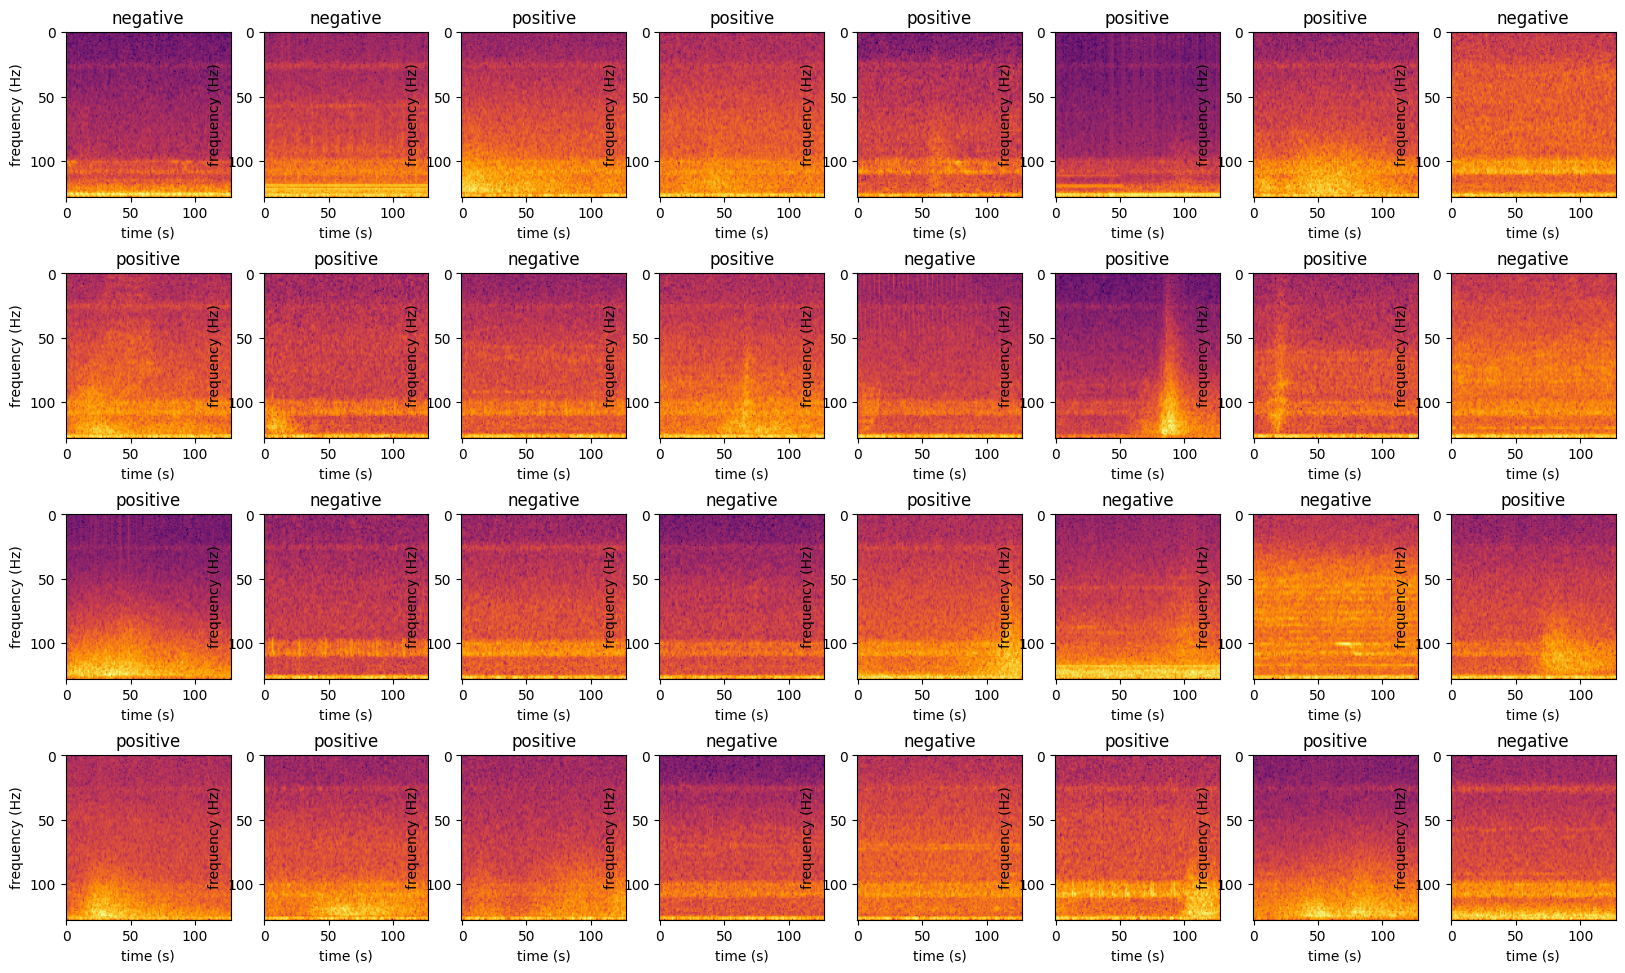

In [17]:
cols = 8
lines = 4
batch_number = 1  # number of the batch we want to inspect

to_show = cols * lines
plt.figure(figsize=(20, lines*3))
shown=0
for images, y in valid_datasets[0].take(batch_number+to_show//BATCH_SIZE+1):
    if batch_number:
            batch_number -= 1
            continue
    for i in range(min(BATCH_SIZE, to_show-shown)):
        ax1 = plt.subplot(lines, cols, 1 + shown)
        plt.xlabel("time (s)")
        plt.ylabel("frequency (Hz)")
        plt.imshow(images[i].numpy()[:,:,0], cmap='inferno')
        label = "positive" if y[i]==1 else "negative"
        plt.title(label)

        shown += 1
plt.show()

In [18]:
for i in range(FOLDS):
    path_prefix = f'{CHECKPOINTS_DIR}/FOLD-{i}'
    history_file = f'{path_prefix}/history.pkl'
    
    if os.path.isfile(history_file):
        print(f"fold {i} already has an history file, skipping it")
        continue
        
    print(f"starting training of fold {i}")
    m = model()
    m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.losses.binary_crossentropy,
        metrics=['Accuracy','AUC'])

    m.build((BATCH_SIZE, SIZE, SIZE, CHANNELS))

    if i==0:
        m.summary()

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{path_prefix}/cp-{{epoch:04d}}.ckpt', save_weights_only=True, verbose=1)

    history = m.fit(
            train_datasets[i],
            batch_size=BATCH_SIZE,
            validation_data=valid_datasets[i],
            epochs=EPOCHS,
            callbacks=[cp_callback]
        )
    
    with open(history_file, 'wb') as f:
        pickle.dump(history.history, f)

starting training of fold 0
Model: "custom_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_52 (Conv2D)          (None, 128, 128, 16)      1040      
                                                                 
 conv2d_53 (Conv2D)          (None, 128, 128, 16)      16400     
                                                                 
 conv2d_54 (Conv2D)          (None, 128, 128, 16)      16400     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                     

KeyboardInterrupt: 

In [ ]:
path_prefix = f'{CHECKPOINTS_DIR}/all'
history_file = f'{path_prefix}/history.pkl'

print(f"starting training with all data")
m = model()
m.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.losses.binary_crossentropy,
    metrics='Accuracy')

m.build((BATCH_SIZE, SIZE, SIZE, CHANNELS))

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{path_prefix}/cp-{{epoch:04d}}.ckpt', save_weights_only=True, verbose=1)

history = m.fit(
        all_train_dataset,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[cp_callback]
    )

with open(history_file, 'wb') as f:
        pickle.dump(history.history, f)

In [ ]:
cols = 8
lines = 4
batch_number = 1

to_show = cols * lines
plt.figure(figsize=(20, lines*3))
shown=0
for images, y in valid_datasets[0].take(batch_number+to_show//BATCH_SIZE+1):
    if batch_number:
            batch_number -= 1
            continue
    for i in range(min(BATCH_SIZE, to_show-shown)):
        ax1 = plt.subplot(lines, cols, 1 + shown)
        plt.xlabel("time (s)")
        plt.ylabel("frequency (Hz)")
        plt.imshow(images[i].numpy()[:,:,0], cmap='inferno')
        label = "positive" if y[i]==1 else "negative"
        predicted = model.predict(np.reshape(images[i], (1, SIZE[0], SIZE[1], CHANNELS)), verbose=False)[0]
        predicted_label = "positive" if predicted>=0.5 else "negative"
        plt.title(f"{predicted_label}/{label}")

        shown += 1
plt.show()